In [1]:
# Colab Requirements
!pip install spectral
import spectral
from google.colab import drive, files
## Mounting Google Drive
drive.mount('/content/drive')
## Basics
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
import time
import numpy
import numpy as np
import pandas as pd
from PIL import Image
from operator import truediv
import scipy.io as sio
import os
import seaborn as sns
## Ploting
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline
## Sklearn 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
## Dimensionality Reduction Methods
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA, SparsePCA, TruncatedSVD
## Deep Model
import keras, h5py
from keras.layers import Input, Conv2D, Conv3D, Flatten, Dense, Reshape, Dropout
#from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.optimizers import Adam

     |████████████████████████████████| 215kB 5.2MB/s 
Mounted at /content/drive


# **Downloading and Loading Hyperspectral Image Dataset**

In [2]:
## Load HSI Dataset
def LoadHSIData(method):
    ## Please reload if downloading error appear.
    HSI_url = ['http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat',
           'http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat']
    for i in range(2):
        file_name = HSI_url[i].split('/')[-1]
        data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab'+str(file_name))
        if os.path.exists(data_path) == False:
            print("Downloading data file from %s to %s" % (HSI_url[i], data_path))
            urllib.request.urlretrieve(url=HSI_url[i], filename=data_path)
            print(str(file_name)+" is Successfully downloaded")
        else:
            print(str(file_name) + " already exist")
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab')
    HSI = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    GT = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    return HSI, GT

# **Dimensional Reduction Methods**

In [3]:
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA': ## Incremental PCA
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
          inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'KPCA': ## Kernel PCA
        kpca = KernelPCA(kernel = "rbf", n_components = NC, gamma = None, 
                         fit_inverse_transform = True, random_state = 2019, 
                         n_jobs=1)
        kpca.fit(RHSI)
        RHSI = kpca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SPCA': ## Sparse PCA
        sparsepca = SparsePCA(n_components = NC, alpha=0.0001, random_state=2019, n_jobs=-1)
        sparsepca.fit(RHSI)
        RHSI = sparsepca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SVD': ## Singular Value Decomposition
        SVD_ = TruncatedSVD(n_components = NC,algorithm = 'randomized', 
                            random_state = 2019, n_iter=5)
        SVD_.fit(RHSI)
        RHSI = SVD_.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

# **Train Test Split**

In [4]:
def TrTeSplit(HSI, GT, testRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size = testRatio, 
                                        random_state = randomState,
                                        stratify = GT)
    return Tr, Te, TrC, TeC

# **Padding and Pacthes**

In [5]:
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

def ImageCubes(HSI, GT, WS = 5, removeZeroLabels = True):
    margin = int((WS - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    # split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

# **Computing Accuracies and Assigning Class Labels**

In [6]:
def ClassificationReports(TeC, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn','Grass-pasture',
                    'Grass-trees', 'Grass-mowed', 'Hay-windrowed', 'Oats', 
                    'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 
                    'Wheat', 'Woods', 'Buildings', 'Stone-Steel']
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    counter = confusion.shape[0]
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

# **Writing Accuracy in CSV file**

In [7]:
def CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa):
    classification = str(classification)
    confusion = str(confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} DL_Time'.format(DL_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Kappa accuracy (%)'.format(kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Overall accuracy (%)'.format(oa))
      CSV_file.write('\n')
      CSV_file.write('{} Average accuracy (%)'.format(aa))
      CSV_file.write('\n')
      CSV_file.write('\n')
      CSV_file.write('{}'.format(classification))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(confusion))
    return CSV_file

# **Plot and Save Confusion Matrix**

In [8]:
def Conf_Mat(Te_Pred, TeC, target_names):
    plt.rcParams.update({'font.size': 12})
    Te_Pred = np.argmax(Te_Pred, axis=1)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred, labels=np.unique(np.argmax(TeC, axis=1)))
    cm_sum = np.sum(confusion, axis=1, keepdims=True)
    cm_perc = confusion / cm_sum.astype(float) * 100
    annot = np.empty_like(confusion).astype(str)
    nrows, ncols = confusion.shape
    for l in range(nrows):
      for m in range(ncols):
        c = confusion[l, m]
        p = cm_perc[l, m]
        if l == m:
          s = cm_sum[l]
          annot[l, m] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
          annot[l, m] = ''
        else:
          annot[l, m] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
    return cm, annot

#**Global Parameters**

In [9]:
HSID = "IP"
Num_Classes = 16
DLM = "PCA"     ## "PCA", "iPCA", "SPCA", "KPCA", "SVD"
WS = 11         ## 9, 11, 13, 15, 17, 19, 21, 23, 25
TeRatio = 0.50  ## Percentage of Test Samples
VeRatio = 0.50  ## Percentage of Validation Samples
k = 15          ## 15, 17, 19, 21, 23, 25, 27, 30 -- # of Dimensions
adam = Adam(lr = 0.001, decay = 1e-06)

# **Main Function for Dimensional Reduction and Creating Patchs for CNN**

In [10]:
HSI, GT = LoadHSIData(HSID)
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
## Split Train and Test sets (for 2D and 3D Models)
Tr, Te, TrC, TeC = TrTeSplit(CRDHSI, CGT, TeRatio)
## Split Train and Validation (for 2D and 3D Models)
Tr, Va, TrC, VaC = TrTeSplit(Tr, TrC, VeRatio)
## Reshape Train, Validation, and Test sets
Tr = Tr.reshape(-1, WS, WS, k, 1)
TrC = np_utils.to_categorical(TrC)
Va = Va.reshape(-1, WS, WS, k, 1)
VaC = np_utils.to_categorical(VaC)
Te = Te.reshape(-1, WS, WS, k, 1)
TeC = np_utils.to_categorical(TeC)

Indian_pines_corrected.mat already exist
Indian_pines_gt.mat already exist


# 3-D CNN

Epoch 1/50
11/11 [==============================] - 8s 636ms/step - loss: 2.5581 - accuracy: 0.2015 - val_loss: 1.9172 - val_accuracy: 0.4145
Epoch 2/50
11/11 [==============================] - 6s 584ms/step - loss: 1.7945 - accuracy: 0.4449 - val_loss: 1.5259 - val_accuracy: 0.5113
Epoch 3/50
11/11 [==============================] - 6s 584ms/step - loss: 1.3898 - accuracy: 0.5224 - val_loss: 1.2218 - val_accuracy: 0.5496
Epoch 4/50
11/11 [==============================] - 6s 579ms/step - loss: 1.1082 - accuracy: 0.5964 - val_loss: 1.1024 - val_accuracy: 0.5687
Epoch 5/50
11/11 [==============================] - 6s 580ms/step - loss: 0.9106 - accuracy: 0.6550 - val_loss: 0.7838 - val_accuracy: 0.7166
Epoch 6/50
11/11 [==============================] - 6s 581ms/step - loss: 0.7091 - accuracy: 0.7508 - val_loss: 0.9366 - val_accuracy: 0.6721
Epoch 7/50
11/11 [==============================] - 6s 577ms/step - loss: 0.8592 - accuracy: 0.7085 - val_loss: 0.7095 - val_accuracy: 0.7393
Epoch 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

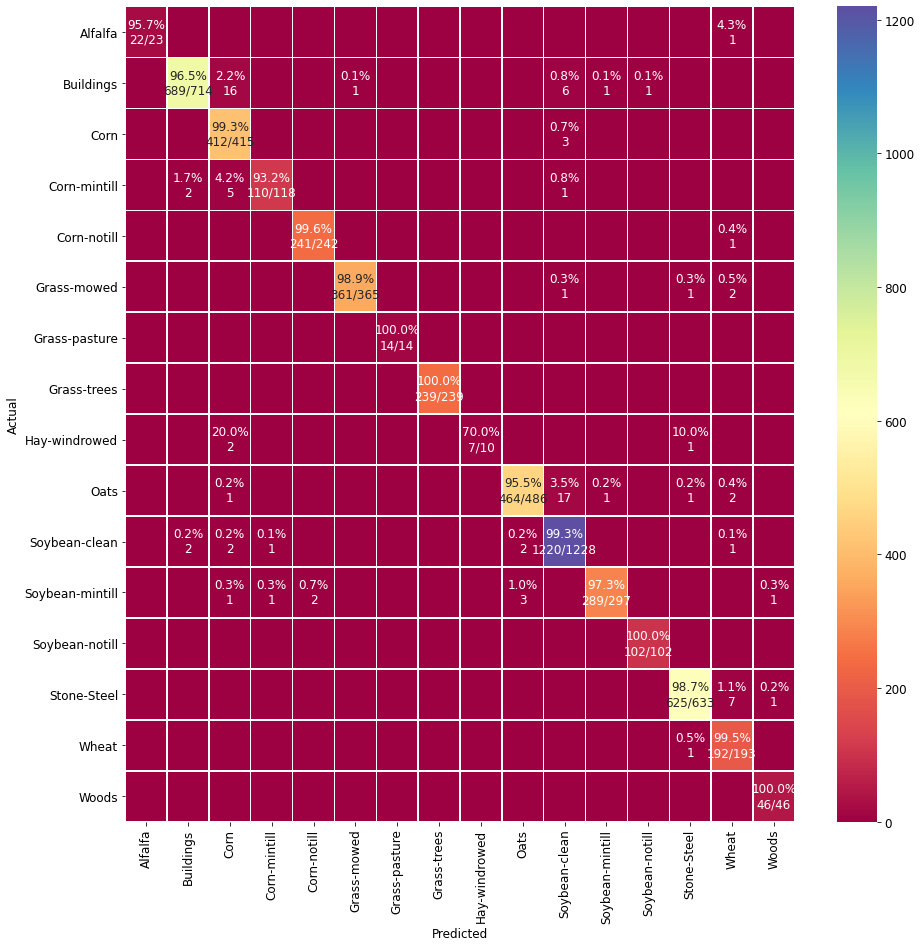

In [11]:
input_layer = Input((WS, WS, k, 1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
output_layer = Dense(units = Num_Classes, activation='softmax')(dense_layer2)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
## Training Time and Fit the Model 
start = time.time()
history1 = model.fit(x=Tr, y=TrC, batch_size=256, epochs=50, validation_data=(Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Prediction and Computing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
print(classification)
## Writing Results in CSV File
file_name = str(WS)+str(DLM)+str(k)+"_Classification_Report_3-D_CNN.csv"
CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa)
files.download(file_name)
## Writing Confusion Matrix
file_name = str(WS)+str(DLM)+str(k)+"_Confusion_Matrix_3-D_CNN.png"
cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.5)
plt.savefig(file_name, dpi=500)
files.download(file_name)

# **Hybrid Model**

Epoch 1/50
11/11 [==============================] - 7s 597ms/step - loss: 2.5834 - accuracy: 0.1757 - val_loss: 1.7910 - val_accuracy: 0.4684
Epoch 2/50
11/11 [==============================] - 6s 585ms/step - loss: 1.6801 - accuracy: 0.4613 - val_loss: 1.4192 - val_accuracy: 0.4879
Epoch 3/50
11/11 [==============================] - 6s 579ms/step - loss: 1.4516 - accuracy: 0.4790 - val_loss: 1.2127 - val_accuracy: 0.5601
Epoch 4/50
11/11 [==============================] - 6s 579ms/step - loss: 1.2266 - accuracy: 0.5637 - val_loss: 1.0020 - val_accuracy: 0.6327
Epoch 5/50
11/11 [==============================] - 6s 577ms/step - loss: 0.9823 - accuracy: 0.6301 - val_loss: 0.8499 - val_accuracy: 0.6823
Epoch 6/50
11/11 [==============================] - 6s 581ms/step - loss: 0.9548 - accuracy: 0.6833 - val_loss: 0.7400 - val_accuracy: 0.7252
Epoch 7/50
11/11 [==============================] - 6s 581ms/step - loss: 0.7288 - accuracy: 0.7507 - val_loss: 0.6339 - val_accuracy: 0.7654
Epoch 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

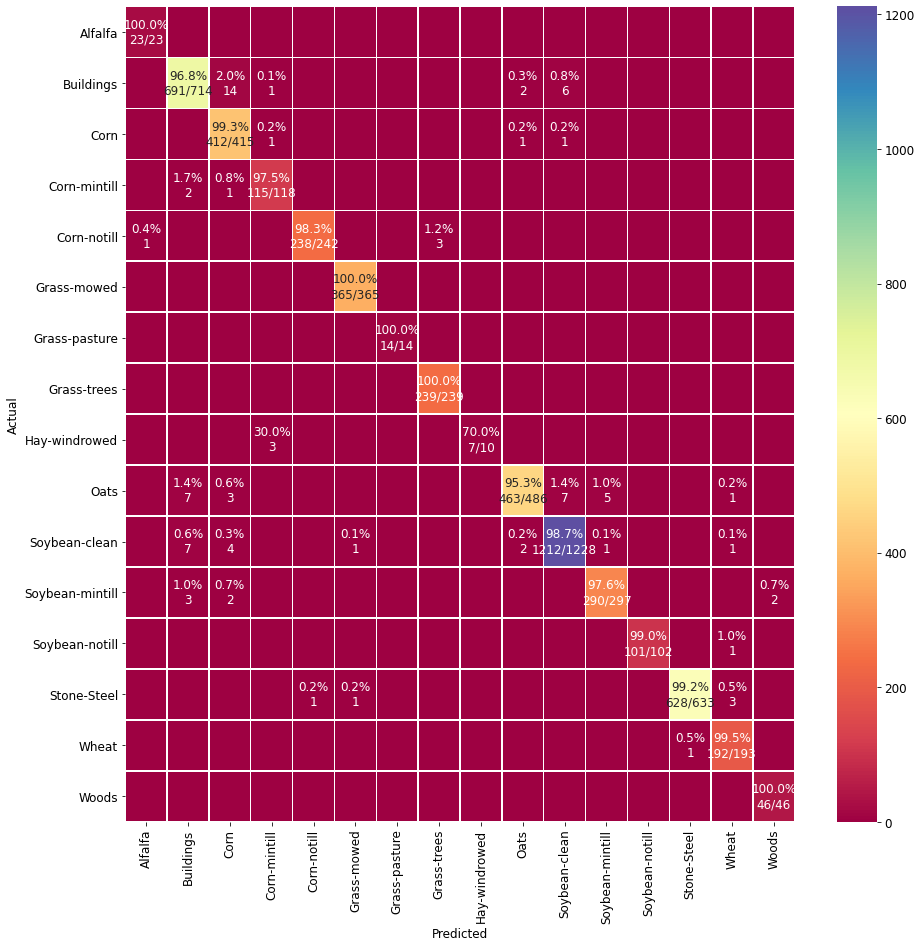

In [12]:
input_layer = Input((WS, WS, k, 1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
##conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 1), activation='relu')(conv_layer3)
## Conv3D with kernel_size=(3, 3, 1) can be used as well instead to reshape and Con2D.
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation = 'relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units = 128, activation = 'relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units = Num_Classes, activation = 'softmax')(dense_layer2)
# Define the Model with Input and Output Layers
model = Model(inputs = input_layer, outputs = output_layer)
## Compiling Hybrid CNN
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
## Fit the Model
start = time.time()
history2 = model.fit(x = Tr, y = TrC, batch_size = 256, epochs = 50, validation_data = (Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Prediction and Computing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
print(classification)
## Writing Results in CSV File
file_name = str(WS)+str(DLM)+str(k)+"_Classification_Report.csv"
CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa)
files.download(file_name)
## Writing Confusion Matrix
file_name = str(WS)+str(DLM)+str(k)+"_Confusion_Matrix.png"
cm, annot = Conf_Mat(Te_Pred, TeC, target_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, cmap= "Spectral", annot=annot, fmt='', ax=ax, linewidths=0.5)
plt.savefig(file_name, dpi=500)
files.download(file_name)

# **Plot Training and Validation Accuracy and Loss**

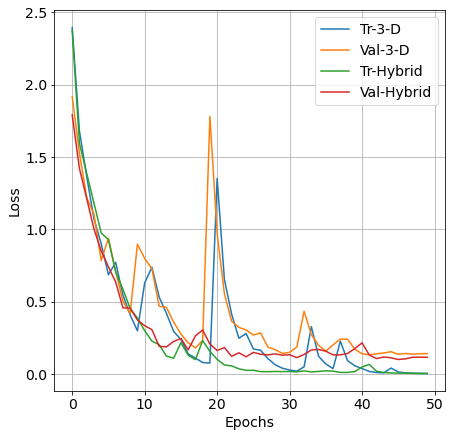

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

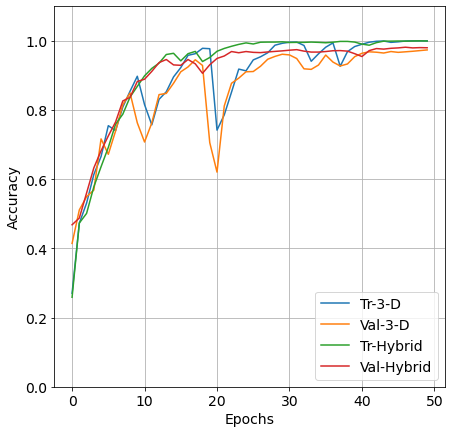

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(7,7)) 
plt.rcParams.update({'font.size': 14})
plt.grid() 
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss']) 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss']) 
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
#plt.title(str(WS)+str(DLM)+str(k)+'_Loss')
plt.legend(['Tr-3-D','Val-3-D', 'Tr-Hybrid','Val-Hybrid'], loc='upper right')
plt.savefig(str(WS)+str(DLM)+str(k)+"_loss_curve.png")
plt.show()
files.download(str(WS)+str(DLM)+str(k)+"_loss_curve.png")

plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.title(str(WS)+str(DLM)+str(k)+'_Accuracy')
plt.legend(['Tr-3-D','Val-3-D', 'Tr-Hybrid','Val-Hybrid'], loc='lower right')
plt.savefig(str(WS)+str(DLM)+str(k)+"_acc_curve.png")
plt.show()
files.download(str(WS)+str(DLM)+str(k)+"_acc_curve.png")